Méthodes d'ensemble
===================

## Preamble



### Imports



In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, make_scorer

import pickle

import warnings
warnings.filterwarnings("ignore")

### Functions



In [2]:
# Display all
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df)

## Global variables

In [3]:
RANDOM_STATE = 42

## Model Selection



### Load Data



In [4]:
df = pd.read_csv('data/train.csv')

display_all(df.describe(include='all').T)

,count,mean,std,min,25%,50%,75%,max
MedInc,14447.0,3.872819,1.894668,0.499900,2.567150,3.534100,4.740750,15.000100
HouseAge,14447.0,28.621998,12.578362,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,14447.0,5.408829,2.098612,0.846154,4.436294,5.219212,6.045171,62.422222
AveBedrms,14447.0,1.093358,0.376803,0.444444,1.006663,1.048936,1.099567,15.312500
Population,14447.0,1428.049145,1135.238659,5.000000,792.000000,1172.000000,1722.000000,35682.000000
AveOccup,14447.0,3.043594,10.545143,0.692308,2.427452,2.815725,3.276349,1243.333333
Latitude,14447.0,35.620210,2.137380,32.540000,33.930000,34.250000,37.710000,41.950000
Longitude,14447.0,-119.554523,2.000330,-124.350000,-121.760000,-118.480000,-118.000000,-114.310000
AvePrice,14447.0,2.068723,1.153981,0.149990,1.197500,1.797000,2.649000,5.000010


In [5]:
X = df.drop('AvePrice', axis=1).to_numpy()
y = df['AvePrice'].to_numpy()

### Training



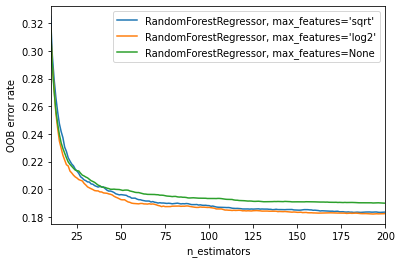

In [6]:
ensemble_rfs = [
    (
        "RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestRegressor, max_features=None",
        RandomForestRegressor(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_rfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 200

for label, rf in ensemble_rfs:
    for i in range(min_estimators, max_estimators + 1):
        rf.set_params(n_estimators=i)
        rf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - rf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, rf_err in error_rate.items():
    xs, ys = zip(*rf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [7]:
rf = RandomForestRegressor(RANDOM_STATE)

grid = {
    'n_estimators': [400, 800],
    'max_samples': [0.8, 1],
    'max_features': ['log2'],
    'max_depth' : [6,8,10,12],
    'oob_score': [True]
}

best_score = 0
for g in ParameterGrid(grid):
    rf.set_params(**g)
    rf.fit(X,y)
    if rf.oob_score_ > best_score:
        best_score = rf.oob_score_
        best_grid = g

print("OOB: %0.5f" % best_score) 
print("Grid:", best_grid)

OOB: 0.80473
Grid: {'max_depth': 12, 'max_features': 'log2', 'max_samples': 0.8, 'n_estimators': 400, 'oob_score': True}


In [8]:
rf.set_params(**best_grid)
rf.fit(X,y)

RandomForestRegressor(max_depth=12, max_features='log2', max_samples=0.8,
                      n_estimators=400, oob_score=True)

In [9]:
y_pred = rf.predict(X)
r2 = r2_score(y, y_pred)
print('R2:', r2)
mae = mean_absolute_error(y, y_pred)
print('Mean Squared Error:', mae)
msle = mean_squared_log_error(y, y_pred)
print('Mean Squared Log Error:', msle)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print('Root Mean Squared Error:', rmse)

R2: 0.9063774656241311
Mean Squared Error: 0.25114373410877244
Mean Squared Log Error: 0.01204357802523679
Root Mean Squared Error: 0.35308049087021687


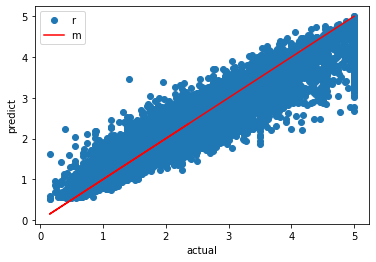

In [10]:
plt.plot(y,y_pred,'o')
plt.plot(y, y, "r-", label= "y=x")
plt.title('')
plt.legend(f'rmse = {rmse}')
plt.xlabel('actual')
plt.ylabel('predict')
plt.plot
plt.show()

### Save best model



In [11]:
with open('data/RF_california.pkl', 'wb') as file:
    pickle.dump(rf, file)

## Bibliography



### References


[california.bib](california.bib)

